# Comparing Wavelength Response Functions in `aiapy` and SSW

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.io
import astropy.time
from sunpy.io.special import read_genx
import hissw

from aiapy.response import Channel

%matplotlib inline

## SSW

First, calculate the effective area for all channels using SSW.

In [2]:
now = astropy.time.Time.now()

In [3]:
channels = [94,131,171,193,211,304,335]

In [4]:
ssw = hissw.ScriptMaker(ssw_packages=['sdo/aia'],ssw_paths=['aia'])

In [5]:
script = """
ea_uncorrected = aia_get_response(/area,/dn,evenorm=0)
ea_eve = aia_get_response(/area,/dn,timedepend_date='{{obstime}}',version=8,evenorm=1)
ea_now = aia_get_response(/area,/dn,timedepend_date='{{obstime}}',version=8,evenorm=0)
"""

In [6]:
res = ssw.run(
    script,
    save_vars=['ea_uncorrected', 'ea_eve', 'ea_now'],
    args={'obstime': now.tai.isot,},
    verbose=False
)

In [7]:
response_ssw = {
    c: {'uncorrected':
        {'wavelength': res['ea_uncorrected'][f'A{c}'][0]['wave'][0]*u.angstrom,
         'effective_area': res['ea_uncorrected'][f'A{c}'][0]['ea'][0]*u.cm**2 * u.count / u.photon
        },
        'eve':
        {'wavelength': res['ea_eve'][f'A{c}'][0]['wave'][0]*u.angstrom,
         'effective_area': res['ea_eve'][f'A{c}'][0]['ea'][0]*u.cm**2 * u.count / u.photon
        },
        'now':
        {'wavelength': res['ea_now'][f'A{c}'][0]['wave'][0]*u.angstrom,
         'effective_area': res['ea_now'][f'A{c}'][0]['ea'][0]*u.cm**2 * u.count / u.photon
        },
       }
    for c in channels
}

## `aiapy`

Next, do it in Python. First, read in the correction lookup table ahead of time to save time.

In [8]:
correction_table = astropy.io.ascii.read(
    '/Users/willbarnes/ssw/sdo/aia/response/aia_V8_20171210_050627_response_table.txt')
correction_table['T_START'] = astropy.time.Time(correction_table['T_START'],scale='utc')
correction_table['T_STOP'] = astropy.time.Time(correction_table['T_STOP'],scale='utc')

Read in instrument data ahead of time.

In [9]:
instrument_data = read_genx('/Users/willbarnes/ssw/sdo/aia/response/aia_V8_all_fullinst.genx')

Calculate all wavelength response functions.

In [10]:
response_python = {c: {'uncorrected': {}, 'eve': {}, 'now': {}} for c in channels}
for c in channels:
    chan = Channel(c*u.angstrom, instrument_file=instrument_data)
    response_python[c]['uncorrected']['wavelength'] = chan.wavelength
    response_python[c]['uncorrected']['effective_area'] = chan.wavelength_response()
    response_python[c]['eve']['wavelength'] = chan.wavelength
    response_python[c]['eve']['effective_area'] = chan.wavelength_response(
        obstime=now,
        include_eve_correction=True,
        correction_table=correction_table)
    response_python[c]['now']['wavelength'] = chan.wavelength
    response_python[c]['now']['effective_area'] = chan.wavelength_response(
        obstime=now,
        correction_table=correction_table)

## Compare

Now, plot all channels on top of each other for both the corrected and uncorrected versions.

### Uncorrected

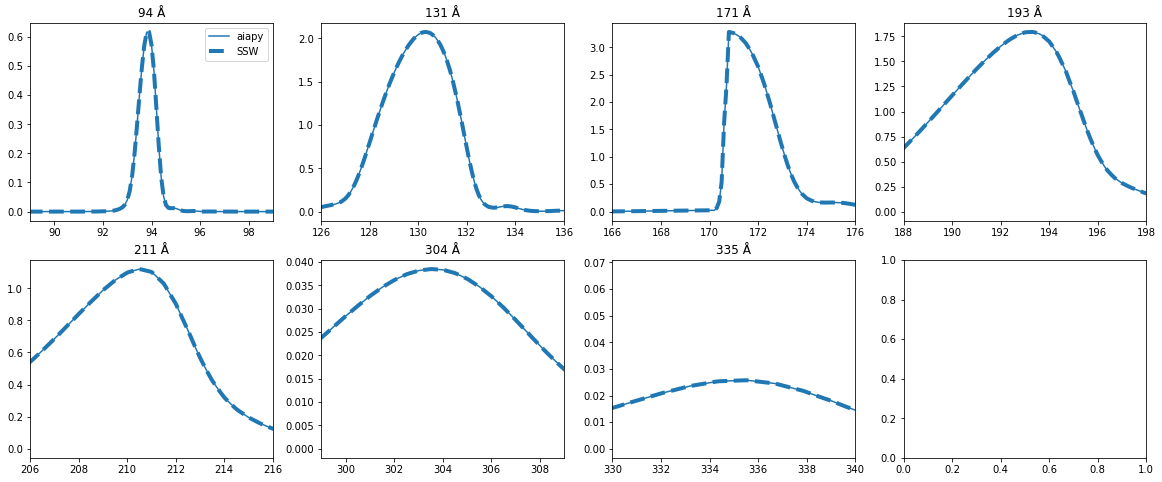

In [11]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    # python
    ax.plot(response_python[c]['uncorrected']['wavelength'],
            response_python[c]['uncorrected']['effective_area'].to(u.cm**2*u.count/u.photon),
            label='aiapy', color='C0', ls='-')
    # SSW
    ax.plot(response_ssw[c]['uncorrected']['wavelength'],
            response_ssw[c]['uncorrected']['effective_area'],
            label='SSW', color='C0', ls='--', lw=4)
    if i==0:
        ax.legend()
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')

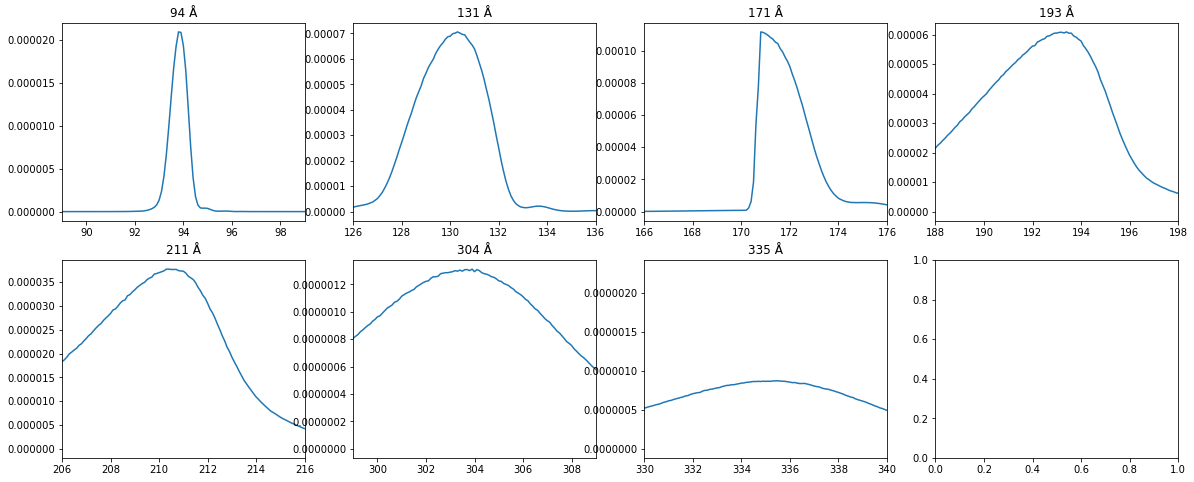

In [12]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    ax.plot(response_python[c]['uncorrected']['wavelength'],
            (response_python[c]['uncorrected']['effective_area'].to(u.cm**2*u.count/u.photon)
             - response_ssw[c]['uncorrected']['effective_area']),
            color='C0', ls='-')
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')
    #ax.set_ylim(-1e-4,1e-4)

### EVE

Then the EVE corrected.

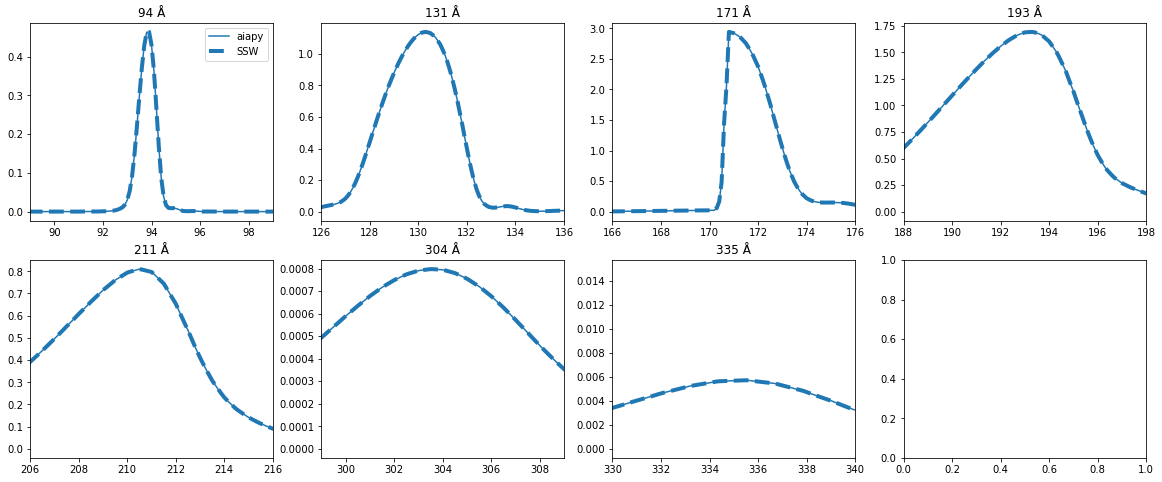

In [13]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    # python
    ax.plot(response_python[c]['eve']['wavelength'],
            response_python[c]['eve']['effective_area'].to(u.cm**2*u.count/u.photon),
            label='aiapy', color='C0', ls='-')
    # SSW
    ax.plot(response_ssw[c]['eve']['wavelength'],
            response_ssw[c]['eve']['effective_area'],
            label='SSW', color='C0', ls='--', lw=4)
    if i==0:
        ax.legend()
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')

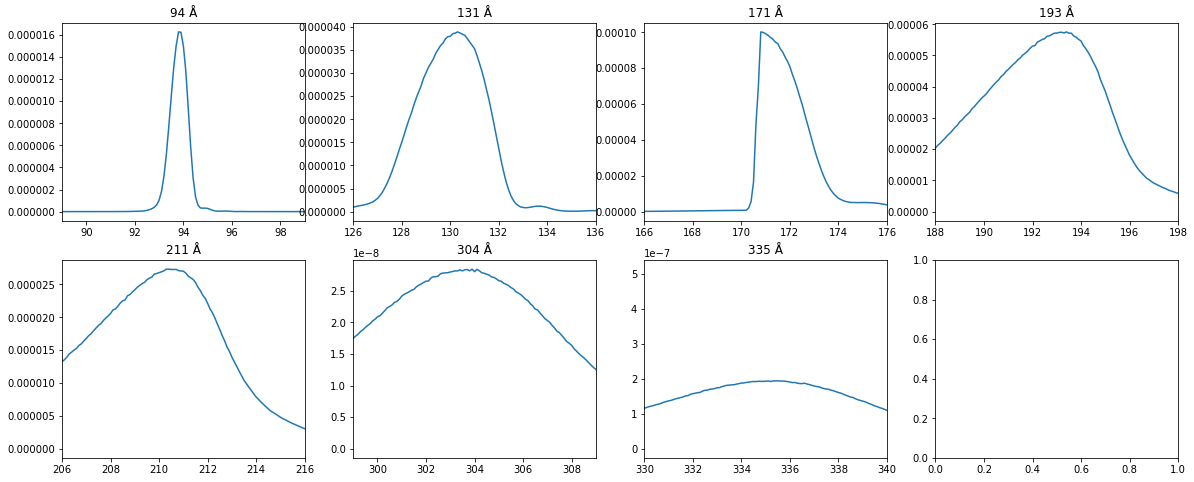

In [14]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    ax.plot(response_python[c]['eve']['wavelength'],
            (response_python[c]['eve']['effective_area'].to(u.cm**2*u.count/u.photon) 
             - response_ssw[c]['eve']['effective_area']),
            color='C0', ls='-')
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')
    #ax.set_ylim(-1e-4,1e-4)

### Time-dependent Only

And then the time corrected 

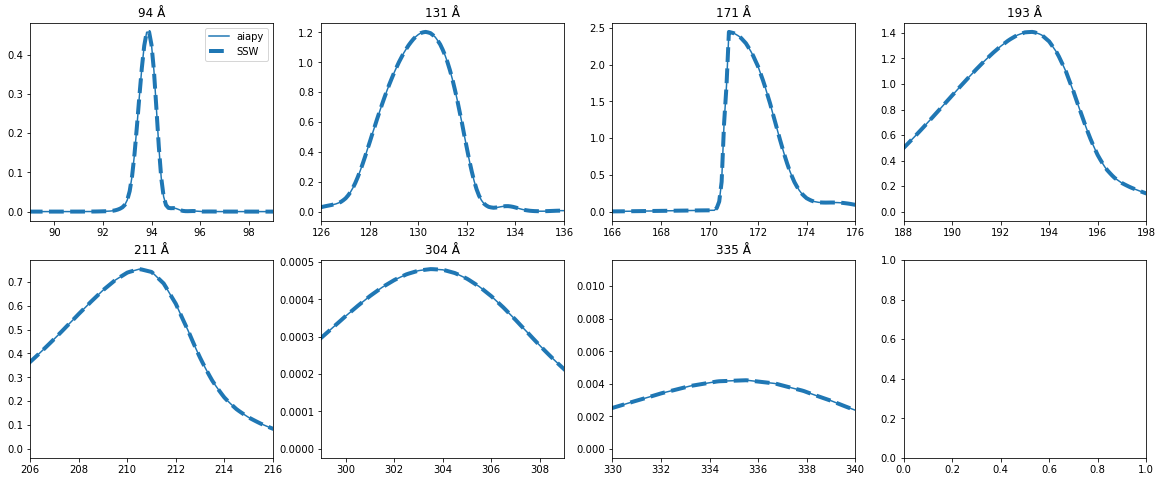

In [15]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    # python
    ax.plot(response_python[c]['now']['wavelength'],
            response_python[c]['now']['effective_area'].to(u.cm**2*u.count/u.photon),
            label='aiapy', color='C0', ls='-')
    # SSW
    ax.plot(response_ssw[c]['now']['wavelength'],
            response_ssw[c]['now']['effective_area'],
            label='SSW', color='C0', ls='--', lw=4)
    if i==0:
        ax.legend()
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')

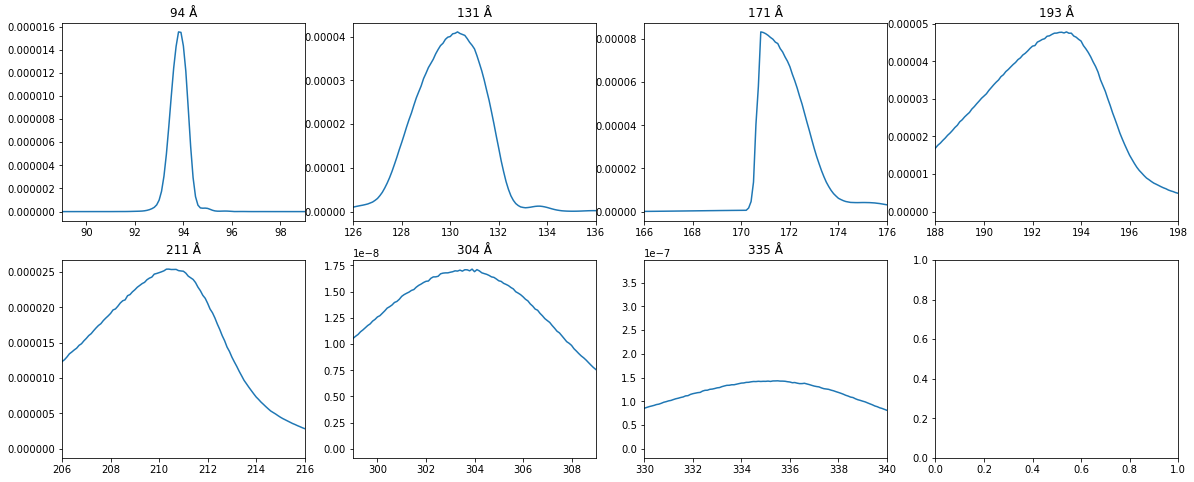

In [16]:
fig,axes = plt.subplots(2,4,figsize=(20,8))
for i,(c,ax) in enumerate(zip(channels, axes.flatten())):
    ax.plot(response_python[c]['now']['wavelength'],
            (response_python[c]['now']['effective_area'].to(u.cm**2*u.count/u.photon) 
             - response_ssw[c]['now']['effective_area']),
            color='C0', ls='-')
    ax.set_xlim(c-5,c+5)
    ax.set_title(f'{c} Å')
    #ax.set_ylim(-1e-4,1e-4)

## Comparing Effective Areas as a Function of Time

Do a quick comparison of the time correction calculation over the lifetime of the mission.

First, load the IDL results produced by Georgios.

In [17]:
ssw_data = read_genx('/Users/willbarnes/Desktop/aiapy-gchintzoglou/response/genx/test_euv_V8_idl.genx')

In [18]:
time_ssw = astropy.time.Time(ssw_data['A']['UTC'],scale='utc')
time_plot = (time_ssw - time_ssw[0]).to(u.year) + (2010 + 5/12 + 1/31)*u.year

In [19]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for i,c in enumerate(ssw_data['A']['EA_OVER_EA0']):
    ax.plot(time_plot,c,label=ssw_data['A']['CHANNELS'][i])
ax.legend()
ax.vlines(np.arange(2010,2020,1),-1000,1000,ls=':',alpha=0.5,lw=1)
ax.legend(loc=3,ncol=3)
ax.set_xlim(time_plot[[0,-1]].to(u.year).value)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('Year of Mission')
ax.set_ylabel(r'$A_{eff}(t)/A_{eff}(t=0)$')

Text(0, 0.5, '$A_{eff}(t)/A_{eff}(t=0)$')

Now, do the calculation in Python over the same time range.

In [20]:
ea_ratio = {c: np.zeros(time_ssw.shape) for c in channels}
for c in channels:
    chan = Channel(c*u.Angstrom, instrument_file=instrument_data)
    ea_ratio[c] = np.array([chan.time_correction(t, correction_table=correction_table)
                            for t in time_ssw])

In [21]:
fig = plt.figure(figsize=(15,8))
ax = fig.gca()
for c in channels:
    ax.plot(time_plot, ea_ratio[c],label=f'{c} Å')
ax.vlines(np.arange(2010,2020,1),-1000,1000,ls=':',alpha=0.5,lw=1)
ax.legend(loc=3,ncol=3)
ax.set_xlim(time_plot[[0,-1]].to(u.year).value)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('Year of Mission')
ax.set_ylabel(r'$A_{eff}(t)/A_{eff}(t=0)$')

Text(0, 0.5, '$A_{eff}(t)/A_{eff}(t=0)$')

Now, compare them directly by plotting the differences

In [22]:
fig,axes = plt.subplots(7,1,figsize=(20,35),sharex=True,sharey=True)
for i,c in enumerate(channels):
    ax = axes.flatten()[i]
    ax.plot(time_plot, ea_ratio[c] - ssw_data['A']['EA_OVER_EA0'][i],)
    ax.set_title(f'{c} Å')
    ax.set_ylabel(r'Python - IDL')

ax.set_xlim(time_plot[[0,-1]].to(u.year).value)
#ax.set_ylim(-5e-8,5e-8)
axes[-1].set_xlabel('Year of Mission')

Text(0.5, 0, 'Year of Mission')